# Part 2 - Classification using fast.ai
In my last year's [eargasm music project](https://github.com/adamsiemaszkiewicz/eargasm-music), I classified my music library using pre-developed audio features extracted using Spotify API. This project is an attempt to test new ways of classifying sounds based on their raw sound representation and, later on, try to ensamble various different methods for a better performing classifier.

This notebook will use the audio clips converted into spectogram images in the previous step to build a classification model using fast.ai.

# Environment setup

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [1]:
# mount Google Drive on the runtime
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# create a symbolic link to a working directory
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/sound_classifier /mydrive

# navigate to the working directory
%cd /mydrive

ln: failed to create symbolic link '/mydrive/sound_classifier': File exists
/content/gdrive/My Drive/Colab Notebooks/sound_classifier


## Import libraries
- `numpy` - linear algebra
- `pandas` -  data manipulation & analysis
- `os` - operating system interfaces
- `tqdm` - progress bars
- `matplotlib` - visualization plotting
- `librosa` - audio & music processing
- `IPython.display` - audio previews

In [3]:
import numpy as np
import pandas as pd
import shutil
import re

## fast.ai
Install & import latest version of fast.ai high-level deep learning library and load its computer vision modules.

In [4]:
!pip install fastai --upgrade

Requirement already up-to-date: fastai in /usr/local/lib/python3.7/dist-packages (2.3.1)


In [5]:
import fastai
print(f'fast.ai version: {fastai.__version__}')
from fastai import *
from fastai.vision import *
from fastai.vision.all import *

fast.ai version: 2.3.1


# Proprocessing
Prepare the data for training

## Load meta data

In [6]:
# path to csv file containing meta data for the dataset
META_CSV = './ESC-50/meta/esc50.csv'

df = pd.read_csv(META_CSV)
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


## Reproducability
Set the global seed to ensure reproducability throughout the code.

In [7]:
set_seed(0)

## Dataset
Let's set the path where our dataset is located and see how our data is stored.

### Path
Set the main dataset path and list the files.

In [8]:
path = Path('./spectograms/')
path.ls()

(#2007) [Path('spectograms/3-152007-A-20.png'),Path('spectograms/3-152007-B-20.png'),Path('spectograms/3-152007-C-20.png'),Path('spectograms/3-152007-D-20.png'),Path('spectograms/3-152007-E-20.png'),Path('spectograms/3-152020-A-36.png'),Path('spectograms/3-152020-B-36.png'),Path('spectograms/3-152020-C-36.png'),Path('spectograms/3-152039-A-3.png'),Path('spectograms/3-152039-B-3.png')...]

### Duplicate files
Due to some Google Drive related bugs there might be some duplicate files. Let's clean them up.

In [9]:
# iterate through the files in the dataset path
for fname in os.listdir(path):

  # drop the file extension
  name = fname.split('.')[0]
  # check if the filename ends with (1) and remove the file
  if name.endswith('(1)'):
    print(os.path.join(path, fname))
    os.remove(os.path.join(path, fname))

### Cross-validation folds
The dataset is divided into 5 folds which we need to keep in order to avoid data leakage, as some of the audio files come from the same recording. Let's keep each fold seperately in their corresponding folder.

#### List files

In [10]:
FOLDS_NUMBER = 5
folds_dict = {
          f'fold{n+1}':[f for f in df.loc[df['fold'] == n+1].filename] \
          for n in range(FOLDS_NUMBER)
         }

df_folds = pd.DataFrame(folds_dict)
df_folds.head()

,fold1,fold2,fold3,fold4,fold5
0,1-100032-A-0.wav,2-100648-A-43.wav,3-100018-A-18.wav,4-102844-A-49.wav,5-103415-A-2.wav
1,1-100038-A-14.wav,2-100786-A-1.wav,3-100024-A-27.wav,4-102844-B-49.wav,5-103416-A-2.wav
2,1-100210-A-36.wav,2-101676-A-10.wav,3-100024-B-27.wav,4-102844-C-49.wav,5-103418-A-2.wav
3,1-100210-B-36.wav,2-102414-A-17.wav,3-101381-A-33.wav,4-102871-A-42.wav,5-103420-A-2.wav
4,1-101296-A-19.wav,2-102414-B-17.wav,3-101381-B-33.wav,4-107117-A-33.wav,5-103421-A-2.wav


#### Create directories
Create folders for each fold to store the spectogram files.

In [11]:
# iterate through folds
for fold in df_folds.columns:
  # set the directory path
  dir = path/fold
  # create folder if it doesn't exist yet
  if not os.path.isdir(dir):
    os.mkdir(dir)
    print(f'Directory {dir} created.')
  else:
    print(f'Directory {dir} already exists.')

Directory spectograms/fold1 already exists.
Directory spectograms/fold2 already exists.
Directory spectograms/fold3 already exists.
Directory spectograms/fold4 already exists.
Directory spectograms/fold5 already exists.


#### Copy files

In [12]:
# iterate through folds
for fold in df_folds.columns:
  # iterate through files within a fold
  for file in df_folds[fold]:
    # change file extension from wav to png
    file = re.sub('wav', 'png', file)
    # check if file already exists
    if not os.path.exists(path/fold/file):
      # copy the file from source to destination
      shutil.copy(path/file, path/fold)
      print(f'Copied {file} to {fold}')
    else:
      print(f'File {file} already exists.')

File 1-100032-A-0.png already exists.
File 1-100038-A-14.png already exists.
File 1-100210-A-36.png already exists.
File 1-100210-B-36.png already exists.
File 1-101296-A-19.png already exists.
File 1-101296-B-19.png already exists.
File 1-101336-A-30.png already exists.
File 1-101404-A-34.png already exists.
File 1-103298-A-9.png already exists.
File 1-103995-A-30.png already exists.
File 1-103999-A-30.png already exists.
File 1-104089-A-22.png already exists.
File 1-104089-B-22.png already exists.
File 1-105224-A-22.png already exists.
File 1-110389-A-0.png already exists.
File 1-110537-A-22.png already exists.
File 1-115521-A-19.png already exists.
File 1-115545-A-48.png already exists.
File 1-115545-B-48.png already exists.
File 1-115545-C-48.png already exists.
File 1-115546-A-48.png already exists.
File 1-115920-A-22.png already exists.
File 1-115920-B-22.png already exists.
File 1-115921-A-22.png already exists.
File 1-116765-A-41.png already exists.
File 1-11687-A-47.png alread

### Labels dictionary
The naming convention of the dataset is `{FOLD}-{CLIP_ID}-{TAKE}-{TARGET}.wav`. Let's create a regex pattern to extract `{TARGET}` from the filenames. Then, accordingly, change the numerical label to the corresponding category name.

In [13]:
# labels_dict = dict(
#     zip(df['target'],
#         df['category'])
#     )
# labels_dict

### Label to category
Let's create a function which will extract a label from the filename and convert it to a corresponding category name.

In [14]:
# def label_func(filename):
#   # create a regex pattern to extract target number
#   pat = r'.-(\d+).png'
#   target = int(re.search(pat, filename).group(1))

#   # convert target number to category name
#   category = labels_dict[target]

#   return category

# Preliminary training
Let's go through the process for one fold first.

## CV folds
Define a function to crate a DataFrame to use in each fold's training.

In [15]:
def fold_df(fold_number):

  # create a test & training sets
  df_train = df.loc[df['fold']!=5, :].copy()

  # tag training and validation samples for a specified fold
  df_train['filename'] = df_train['filename'] \
                        .apply(lambda x: x.split('.')[0])+'.png'
  df_train['is_valid'] = df_train['fold'] \
                        .apply(lambda x: True if x==fold_number else False)

  # get rid of no longer needed columns
  df_train = df_train.drop(
      columns=['fold', 'target', 'esc10', 'src_file', 'take']
      )
  
  # reset index
  df_train = df_train.reset_index(drop=True)
  
  return df_train

In [16]:
fold_df(4)

,filename,category,is_valid
0,1-100032-A-0.png,dog,False
1,1-100038-A-14.png,chirping_birds,False
2,1-100210-A-36.png,vacuum_cleaner,False
3,1-100210-B-36.png,vacuum_cleaner,False
4,1-101296-A-19.png,thunderstorm,False
...,...,...,...
1595,4-99193-B-4.png,frog,True
1596,4-99644-A-4.png,frog,True
1597,4-99644-B-4.png,frog,True
1598,4-99644-C-4.png,frog,True


## Data Loaders
Let's build a DataLoaders object to store....

In [17]:
# create DataLoaders object
dls = ImageDataLoaders.from_df(
    df=fold_df(1),
    path=path,
    fn_col='filename',
    label_col='category',
    valid_col='is_valid',
    item_tfms=Resize(512, method=ResizeMethod.Squish),
    # batch_tfms=RandomCrop(size=256),
    bs=64
    )

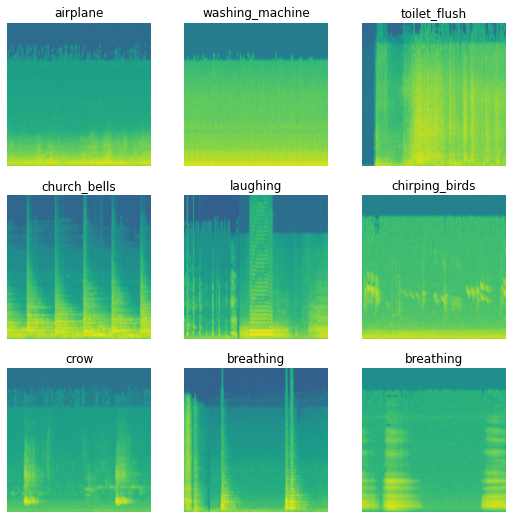

In [18]:
# preview one training batch
dls.train.show_batch()

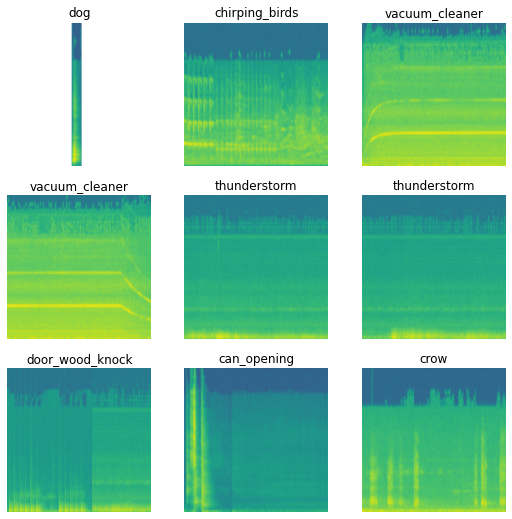

In [19]:
# preview one training batch
dls.valid.show_batch()

## Learner
https://walkwithfastai.com/vision.clas.single_label
Create a convolutional netural network learner with:
- previously made DataLoaders
- resnet34 architecture
- evalutation metrics (error rate & accuracy)
- use transfer learning by importing reset34 weight
- using mixed precision 'to_fp16()'

In [20]:
learn = cnn_learner(
    dls=dls,
    arch=resnet34,
    metrics=[error_rate, accuracy],
    pretrained=True   
    ).to_fp16()

## Initial training
Let's see how out-of-the-box transferred learner does on our dataset.

In [21]:
# learn.fine_tune(1)

The error rate of the OOTB model performed poorly with our spectograms but improves its accuracy quite rapidly.

## Learning rate
Before training further let's find an optimal learning rate for our model to learn quicker. To do so we need to take the steepest point where the curve declines the fastest.

Lowest point: 8.32e-03, steepest point: 9.12e-03


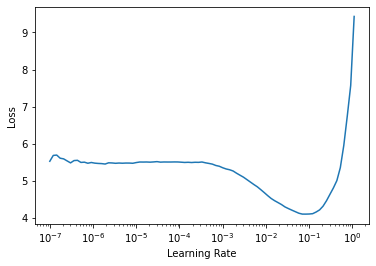

In [22]:
lr_min, lr_steep = learn.lr_find()
print(f'Lowest point: {lr_min:.2e}, steepest point: {lr_steep:.2e}')

## Basic training
Once we have a good learning rate to train our model, let's fine-tune the pretrained model. What the `fine_tune()` method does is it:
- Trains the randomly added layers for one epoch, with all other layers frozen
- Unfreezes all of the layers, and trains them all for the number of epochs requested

In [23]:
learn.fine_tune(20, base_lr=lr_steep)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,4.139255,4.371988,0.862500,0.137500,00:18


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.593489,2.835453,0.690000,0.310000,00:22
1,1.159141,1.751653,0.460000,0.540000,00:21
2,0.827174,1.524999,0.405000,0.595000,00:21
3,0.602123,1.879093,0.412500,0.587500,00:21
4,0.531470,2.461697,0.572500,0.427500,00:21
5,0.534306,3.381283,0.635000,0.365000,00:21
6,0.609391,2.974858,0.540000,0.460000,00:21
7,0.631125,3.247122,0.527500,0.472500,00:21
8,0.562042,2.193442,0.485000,0.515000,00:21
9,0.446693,1.680260,0.372500,0.627500,00:21


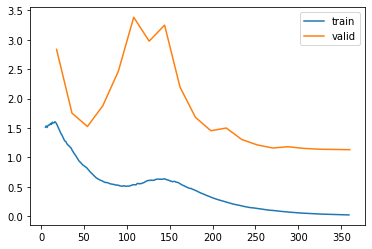

In [24]:
learn.recorder.plot_loss()

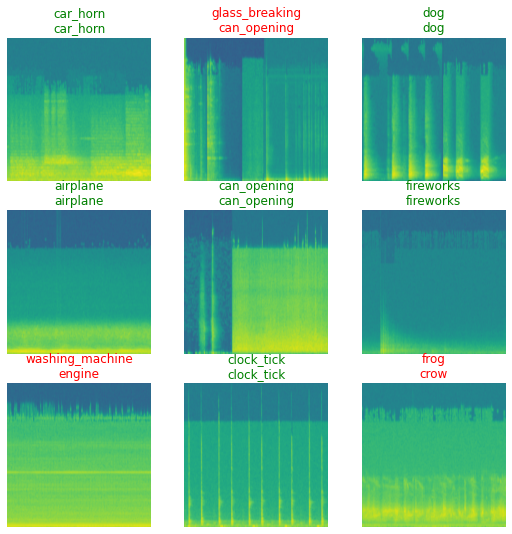

In [26]:
learn.show_results()

## Model interpretation

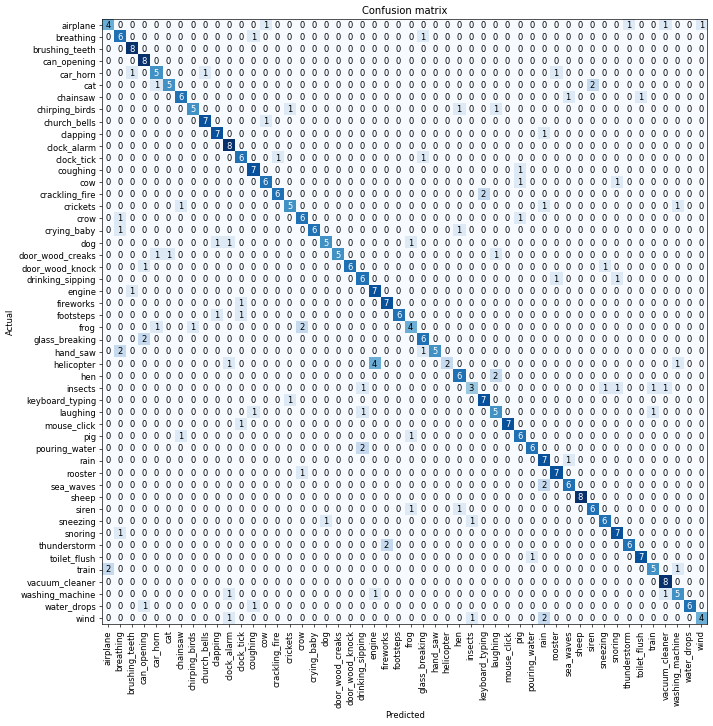

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [29]:
interp.most_confused(min_val=2)

[('helicopter', 'engine', 4),
 ('cat', 'siren', 2),
 ('crackling_fire', 'keyboard_typing', 2),
 ('frog', 'crow', 2),
 ('glass_breaking', 'can_opening', 2),
 ('hand_saw', 'breathing', 2),
 ('hen', 'laughing', 2),
 ('pouring_water', 'drinking_sipping', 2),
 ('sea_waves', 'rain', 2),
 ('thunderstorm', 'fireworks', 2),
 ('train', 'airplane', 2),
 ('wind', 'rain', 2)]

In [48]:
interp.print_classification_report()

                  precision    recall  f1-score   support

        airplane       0.67      0.50      0.57         8
       breathing       0.55      0.75      0.63         8
  brushing_teeth       0.80      1.00      0.89         8
     can_opening       0.67      1.00      0.80         8
        car_horn       0.62      0.62      0.62         8
             cat       0.83      0.62      0.71         8
        chainsaw       0.75      0.75      0.75         8
  chirping_birds       0.83      0.62      0.71         8
    church_bells       0.88      0.88      0.88         8
        clapping       0.78      0.88      0.82         8
     clock_alarm       0.67      1.00      0.80         8
      clock_tick       0.67      0.75      0.71         8
        coughing       0.70      0.88      0.78         8
             cow       0.75      0.75      0.75         8
  crackling_fire       0.86      0.75      0.80         8
        crickets       0.71      0.62      0.67         8
            c

## Test set
https://analyticsindiamag.com/a-hands-on-guide-to-regression-with-fast-ai/

### Test Dataset
Take out one fold to use as our test set to evaluate the performance of the final model.

In [30]:
# create a test set
df_test  = df.loc[df['fold']==5, :].copy()

# change file extensions
df_test['filename'] = df_test['filename'].apply(lambda x: 'fold5/'+x.split('.')[0]+'.png')

# get rid of no longer needed columns
df_test = df_test.loc[:, ['filename', 'category']].reset_index(drop=True)

df_test

,filename,category
0,fold5/5-103415-A-2.png,pig
1,fold5/5-103416-A-2.png,pig
2,fold5/5-103418-A-2.png,pig
3,fold5/5-103420-A-2.png,pig
4,fold5/5-103421-A-2.png,pig
...,...,...
395,fold5/5-263831-B-6.png,hen
396,fold5/5-263902-A-36.png,vacuum_cleaner
397,fold5/5-51149-A-25.png,footsteps
398,fold5/5-61635-A-8.png,sheep


In [31]:
# make test set
tset = test_set(
    dsets=dls.valid_ds,
    test_items=df_test,
    with_labels=True
    )
tset

(#400) [(PILImage mode=RGB size=334x217, TensorCategory(34)),(PILImage mode=RGB size=334x217, TensorCategory(34)),(PILImage mode=RGB size=334x217, TensorCategory(34)),(PILImage mode=RGB size=334x217, TensorCategory(34)),(PILImage mode=RGB size=334x217, TensorCategory(34)),(PILImage mode=RGB size=334x217, TensorCategory(34)),(PILImage mode=RGB size=334x217, TensorCategory(40)),(PILImage mode=RGB size=334x217, TensorCategory(40)),(PILImage mode=RGB size=334x217, TensorCategory(40)),(PILImage mode=RGB size=334x217, TensorCategory(34))...]

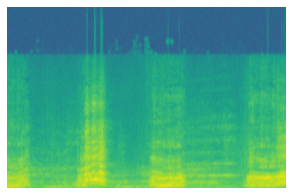

In [32]:
tset[0][0].show()

### Test DataLoader

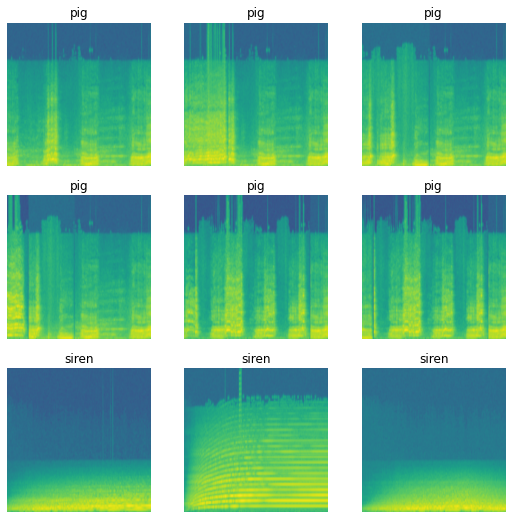

In [33]:
test_dl = dls.test_dl(
    dsets=dls.valid_ds,
    test_items=df_test,
    with_labels=True
    )
test_dl.show_batch()

### Classification results

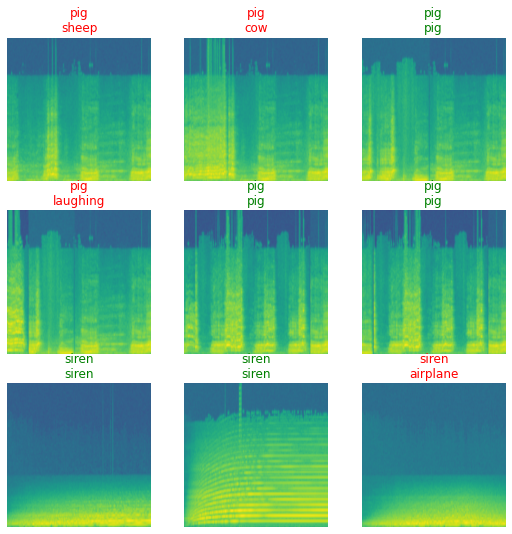

In [44]:
learn.show_results(dl=test_dl)

### Results interpretation

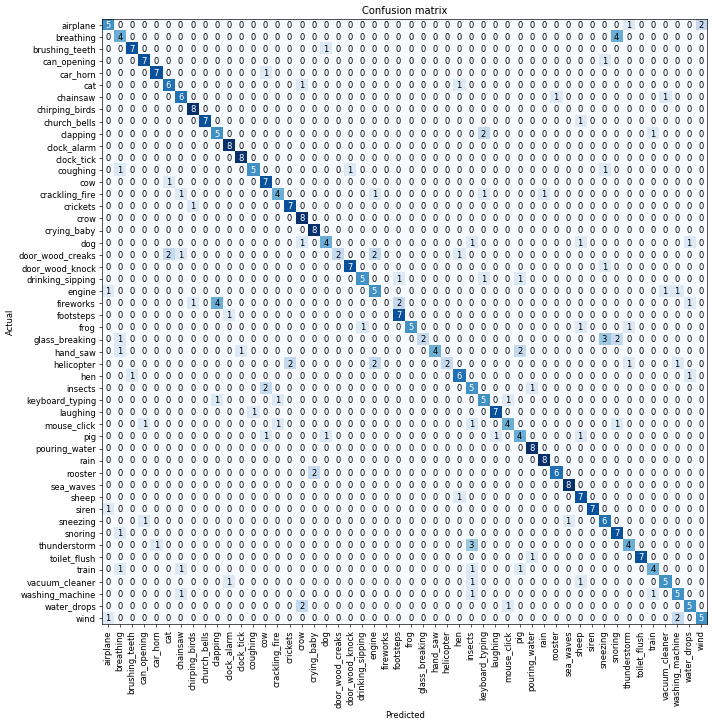

In [50]:
interp_test = ClassificationInterpretation.from_learner(learn, dl=test_dl)
interp_test.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [53]:
interp_test.most_confused(min_val=2)

[('breathing', 'snoring', 4),
 ('fireworks', 'clapping', 4),
 ('glass_breaking', 'sneezing', 3),
 ('thunderstorm', 'insects', 3),
 ('airplane', 'wind', 2),
 ('clapping', 'keyboard_typing', 2),
 ('door_wood_creaks', 'cat', 2),
 ('door_wood_creaks', 'engine', 2),
 ('fireworks', 'footsteps', 2),
 ('glass_breaking', 'snoring', 2),
 ('hand_saw', 'pig', 2),
 ('helicopter', 'crickets', 2),
 ('helicopter', 'engine', 2),
 ('insects', 'cow', 2),
 ('rooster', 'crying_baby', 2),
 ('water_drops', 'crow', 2),
 ('wind', 'washing_machine', 2)]

In [54]:
interp_test.print_classification_report()

                  precision    recall  f1-score   support

        airplane       0.62      0.62      0.62         8
       breathing       0.44      0.50      0.47         8
  brushing_teeth       0.88      0.88      0.88         8
     can_opening       0.78      0.88      0.82         8
        car_horn       0.88      0.88      0.88         8
             cat       0.67      0.75      0.71         8
        chainsaw       0.60      0.75      0.67         8
  chirping_birds       0.80      1.00      0.89         8
    church_bells       1.00      0.88      0.93         8
        clapping       0.50      0.62      0.56         8
     clock_alarm       0.80      1.00      0.89         8
      clock_tick       0.89      1.00      0.94         8
        coughing       0.83      0.62      0.71         8
             cow       0.64      0.88      0.74         8
  crackling_fire       0.67      0.50      0.57         8
        crickets       0.78      0.88      0.82         8
            c

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb
- https://www.kaggle.com/mentalwanderer/image-classification-workflow-with-fast-ai
- https://muellerzr.github.io/fastblog/2020/08/10/testdl.html
- https://muellerzr.github.io/fastblog/2020/08/21/beginner.html
- https://medium.com/analytics-vidhya/image-classification-using-fastai-5ff5b374d414
- https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb
- https://www.kaggle.com/mentalwanderer/image-classification-workflow-with-fast-ai
- https://towardsdatascience.com/audio-classification-using-fastai-and-on-the-fly-frequency-transforms-4dbe1b540f89
- https://www.kaggle.com/drcapa/esc-50-eda-pytorch
- https://www.kaggle.com/sreyareddy15/85-validation-accuracy-tensorflow
- https://www.kaggle.com/aipythoner/fastai-resnet50-pretrained-on-spectrogram
- https://www.kaggle.com/goldeneye007/5-fold-cv-res50-fastai-81-15-accuracy
- https://medium.com/jovianml/classifying-environmental-audio-recordings-9500a2112234
- https://towardsdatascience.com/deep-learning-for-diagnosis-of-skin-images-with-fastai-792160ab5495
- https://wandb.ai/jhartquist/fastaudio-esc-50/reports/Fine-tuning-ResNet-18-for-Audio-Classification--VmlldzoyNjU3OTQ
- https://enzokro.dev/spectrogram_normalizations/2020/09/10/Normalizing-spectrograms-for-deep-learning.html

In [ ]:
def classify(cases, classifier='knn', PCA=False, debug=False):
    results = []
    class_count = len(cases['category'].unique())
    confusion = np.zeros((class_count, class_count), dtype=int)
    
    for fold in range(1, 6):
        train = cases[cases['fold'] != fold].copy()
        test = cases[cases['fold'] == fold].copy()
        classifier_name = ''

        if PCA:
            pca = sk.decomposition.PCA()
            pca.fit(train.loc[:, features_start:features_end])
            train.loc[:, features_start:features_end] = pca.transform(train.loc[:, features_start:features_end])
            test.loc[:, features_start:features_end] = pca.transform(test.loc[:, features_start:features_end])

        if classifier == 'knn':
            classifier_name = 'k-NN'
            knn = sk.neighbors.KNeighborsClassifier(n_neighbors=8)
            knn.fit(train.loc[:, features_start:features_end], train['category'])
            test.loc[:, 'prediction'] = knn.predict(test.loc[:, features_start:features_end])
            
        if classifier == 'rf':
            classifier_name = 'Random Forest'
            rf = sk.ensemble.RandomForestClassifier(n_estimators=500, random_state=20150420)
            rf.fit(train.loc[:, features_start:features_end], train['category'])
            test.loc[:, 'prediction'] = rf.predict(test.loc[:, features_start:features_end])
            
        if classifier == 'svm':
            classifier_name = 'Support Vector Machine (SVM)'
            svm = sk.svm.SVC(C=0.1, kernel='linear', random_state=20150420)
            svm.fit(train.loc[:, features_start:features_end], train['category'])
            test.loc[:, 'prediction'] = svm.predict(test.loc[:, features_start:features_end])

        accuracy = np.sum(test['category'] == test['prediction']) / float(len(test['category']))
        results.append(accuracy)
        confusion_current = sk.metrics.confusion_matrix(test['category'], test['prediction'])
        confusion = confusion + confusion_current
        
        print 'Classifying fold {0} with {1} classifier. Accuracy: {2}%'.format(fold, classifier_name, to_percentage(accuracy))
        if debug:
            print 'Confusion matrix:\n', confusion_current, '\n'
        
    print 'Average accuracy: {0}%\n'.format(to_percentage(np.mean(results)))
    return confusion, results